# ChatGPT-based Portfolio Optimization (Assignment 2 template)

### Importing relevant libraries

In [455]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import requests
import os
import re
import time
from bs4 import BeautifulSoup  # library to parse HTML documents

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.dates import DateFormatter, DayLocator
%matplotlib inline

In [456]:
try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

In [457]:
try:
    import cvxpy as cp
except:
    !pip install cvxpy
    import cvxpy as cp

## ChatGPT API for stock picking (you can use ChatGPT user interface instead)

### Importing relevant libraries needed for GPT API and set parameters

In [458]:
try:
    import openai
except:
    !pip install openai
    import openai

In [459]:
## API Key
API_KEY = ""

os.environ['OPENAI_API_KEY'] = API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

In [460]:
## OpenAI API parameters
model = "gpt-3.5-turbo"  # 4K tokens
# model = "gpt-3.5-turbo-16k"
max_tokens = 1024
n = 1
stop = None
temperature = 0.5

### ChatGPT prompts to extract stock tickers from S&P500 market index and obtain GPT asset weights

Number of stocks in trading universe

In [461]:
Nstocks = 20

In [462]:
prompt1 = "Using a range of investing principles taken from leading funds, create a theoretical fund comprising of atleast "+str(Nstocks)+" stocks (mention their tickers) from the S&P500 with the goal to outperform the S&P500 index"

In [463]:
# Call OpenAI API for the first prompt
response1 = openai.ChatCompletion.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a helpful  assistant."},
        {"role": "user", "content": prompt1},
    ],
    max_tokens=max_tokens,
    n=n,
    stop=stop,
    temperature=temperature,
)

In [464]:
coutput1 = response1['choices'][0]['message']['content']
print(coutput1)

To create a theoretical fund with the goal of outperforming the S&P 500 index, I will consider a range of investing principles followed by leading funds. Please note that this is a hypothetical exercise and not investment advice. Here is a selection of 20 stocks from the S&P 500, along with their tickers:

1. Apple Inc. (AAPL)
2. Microsoft Corporation (MSFT)
3. Amazon.com Inc. (AMZN)
4. Alphabet Inc. (GOOGL)
5. Facebook, Inc. (FB)
6. Johnson & Johnson (JNJ)
7. Visa Inc. (V)
8. JPMorgan Chase & Co. (JPM)
9. Procter & Gamble Company (PG)
10. Walmart Inc. (WMT)
11. UnitedHealth Group Incorporated (UNH)
12. Mastercard Incorporated (MA)
13. The Walt Disney Company (DIS)
14. Home Depot, Inc. (HD)
15. Intel Corporation (INTC)
16. Verizon Communications Inc. (VZ)
17. Coca-Cola Company (KO)
18. PepsiCo, Inc. (PEP)
19. Adobe Inc. (ADBE)
20. NVIDIA Corporation (NVDA)

These stocks have been selected based on factors such as their market capitalization, historical performance, growth potential, an

In [465]:
prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(
    input=coutput1)
print(prompt2)

Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "To create a theoretical fund with the goal of outperforming the S&P 500 index, I will consider a range of investing principles followed by leading funds. Please note that this is a hypothetical exercise and not investment advice. Here is a selection of 20 stocks from the S&P 500, along with their tickers:

1. Apple Inc. (AAPL)
2. Microsoft Corporation (MSFT)
3. Amazon.com Inc. (AMZN)
4. Alphabet Inc. (GOOGL)
5. Facebook, Inc. (FB)
6. Johnson & Johnson (JNJ)
7. Visa Inc. (V)
8. JPMorgan Chase & Co. (JPM)
9. Procter & Gamble Company (PG)
10. Walmart Inc. (WMT)
11. UnitedHealth Group Incorporated (UNH)
12. Mastercard Incorporated (MA)
13. The Walt Disney Company (DIS)
14. Home Depot, Inc. (HD)
15. Intel Corporation (INTC)
16. Verizon Communications Inc. (VZ)
17. Coca-Cola Company (KO)
18. PepsiCo, Inc. (PEP)
19. Adobe Inc. (ADBE)
20. NVIDIA Corporation (NVDA)

These stocks have been selected ba

In [466]:
# Call OpenAI API for the second prompt
response2 = openai.ChatCompletion.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a helpful  assistant."},
        {"role": "user", "content": prompt2},
    ],
    max_tokens=max_tokens,
    n=n,
    stop=stop,
    temperature=temperature,
)

In [467]:
coutput2 = response2['choices'][0]['message']['content']
print(coutput2)

AAPL MSFT AMZN GOOGL FB JNJ V JPM PG WMT UNH MA DIS HD INTC VZ KO PEP ADBE NVDA


In [468]:
# Get stock tickers as a list
stock_tickers = coutput2.split()

# Replace "." with "-"
stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

# Replace "FB" with "META"
stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]

# Print stock tickers as Python list
print(stock_tickers)

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'JNJ', 'V', 'JPM', 'PG', 'WMT', 'UNH', 'MA', 'DIS', 'HD', 'INTC', 'VZ', 'KO', 'PEP', 'ADBE', 'NVDA']


In [469]:
prompt3 = "Assume you're designing a theoretical model portfolio from these S&P500 stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized, i.e., weights should add up to 1.00) in the portfolio to potentially outperform the S&P500 index. Also mention the underlying strategy or logic which you used to assign these weights.".format(
    input=stock_tickers)
print(prompt3)

Assume you're designing a theoretical model portfolio from these S&P500 stocks: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'JNJ', 'V', 'JPM', 'PG', 'WMT', 'UNH', 'MA', 'DIS', 'HD', 'INTC', 'VZ', 'KO', 'PEP', 'ADBE', 'NVDA']. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized, i.e., weights should add up to 1.00) in the portfolio to potentially outperform the S&P500 index. Also mention the underlying strategy or logic which you used to assign these weights.


In [470]:
# Call OpenAI API for the third prompt
response3 = openai.ChatCompletion.create(
    model=model,
    messages=[
        {"role": "system",
         "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
        {"role": "user", "content": prompt3},
    ],
    max_tokens=max_tokens,
    n=n,
    stop=stop,
    temperature=temperature,
)

In [471]:
coutput3 = response3['choices'][0]['message']['content']
print(coutput3)

To create a hypothetical allocation of weights for the stocks in this theoretical investment fund, I will consider a strategy based on diversification and the market capitalization of each stock. The goal is to outperform the S&P500 index while maintaining a balanced and diversified portfolio.

Here is a hypothetical allocation of weights for the stocks:

- AAPL: 0.15
- MSFT: 0.12
- AMZN: 0.10
- GOOGL: 0.08
- META: 0.07
- JNJ: 0.06
- V: 0.05
- JPM: 0.05
- PG: 0.04
- WMT: 0.04
- UNH: 0.03
- MA: 0.03
- DIS: 0.03
- HD: 0.03
- INTC: 0.02
- VZ: 0.02
- KO: 0.02
- PEP: 0.02
- ADBE: 0.01
- NVDA: 0.01

The underlying strategy for assigning these weights is as follows:

1. Market Capitalization: The weightage of each stock is determined based on its market capitalization. Larger companies with higher market capitalizations are given higher weights to reflect their significance in the market.

2. Diversification: The weights are distributed across different sectors and industries to ensure divers

In [472]:
prompt4 = 'From the following text, extract tickers of stocks and corresponding stock weights (seperate tickers from weights with the column sign ":") as a single comma "," separated string, with the weights expressed as floats : "{input}"'.format(
    input=coutput3)
print(prompt4)

From the following text, extract tickers of stocks and corresponding stock weights (seperate tickers from weights with the column sign ":") as a single comma "," separated string, with the weights expressed as floats : "To create a hypothetical allocation of weights for the stocks in this theoretical investment fund, I will consider a strategy based on diversification and the market capitalization of each stock. The goal is to outperform the S&P500 index while maintaining a balanced and diversified portfolio.

Here is a hypothetical allocation of weights for the stocks:

- AAPL: 0.15
- MSFT: 0.12
- AMZN: 0.10
- GOOGL: 0.08
- META: 0.07
- JNJ: 0.06
- V: 0.05
- JPM: 0.05
- PG: 0.04
- WMT: 0.04
- UNH: 0.03
- MA: 0.03
- DIS: 0.03
- HD: 0.03
- INTC: 0.02
- VZ: 0.02
- KO: 0.02
- PEP: 0.02
- ADBE: 0.01
- NVDA: 0.01

The underlying strategy for assigning these weights is as follows:

1. Market Capitalization: The weightage of each stock is determined based on its market capitalization. Larger 

In [473]:
# Call OpenAI API for the fourth prompt
response4 = openai.ChatCompletion.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt4},
    ],
    max_tokens=max_tokens,
    n=n,
    stop=stop,
    temperature=temperature,
)

In [474]:
coutput4 = response4['choices'][0]['message']['content']
print(coutput4)

AAPL:0.15,MSFT:0.12,AMZN:0.10,GOOGL:0.08,META:0.07,JNJ:0.06,V:0.05,JPM:0.05,PG:0.04,WMT:0.04,UNH:0.03,MA:0.03,DIS:0.03,HD:0.03,INTC:0.02,VZ:0.02,KO:0.02,PEP:0.02,ADBE:0.01,NVDA:0.01


In [475]:
## Copy/paste ChatGPT output here if you decide to use ChatGPT user interface instead of API
# coutput4 = "AAPL:0.15, MSFT:0.15, AMZN:0.10, GOOGL:0.10, META:0.05, V:0.05, MA:0.05, JNJ:0.05, PG:0.05, DIS:0.05, HD:0.05, WMT:0.05, NVDA:0.05, ADBE:0.05, CRM:0.05, PYPL:0.05, JPM:0.02, BAC:0.02, BRK-B:0.02, KO:0.02"

In [476]:
prompt1 = "Using a range of investing principles taken from leading funds, create a theoretical fund comprising of atleast " + str(
    Nstocks) + " stocks (mention their tickers) from the S&P500 with the goal to outperform the S&P500 index"

In [477]:
## Convert coutput4 string to Pandas DataFrame

# Remove " from the beginning and end of string
coutput4 = coutput4.strip('"')

# Find all occurrences of stock tickers and weights in the output string
# Assume stock tickers consist of uppercase letters and possibly a hyphen
# Assume weights are decimal numbers possibly represented in scientific notation
matches = re.findall(r"'?([A-Z\-]+)'?[\:\,]\s*([\d\.e\-]+)", coutput4)

# Convert list of matches to a DataFrame
dfGPTweigts = pd.DataFrame(matches, columns=['ticker', 'GPTweights'])

# Convert the 'weight' column to numeric type
dfGPTweigts['GPTweights'] = pd.to_numeric(dfGPTweigts['GPTweights'])
dfGPTweigts.set_index('ticker', inplace=True)

In [478]:
# Make sure that weights sum up to one
dfGPTweigts['GPTweights'] = dfGPTweigts['GPTweights'] / dfGPTweigts['GPTweights'].sum()

In [479]:
dfGPTweigts.to_dict()


{'GPTweights': {'AAPL': 0.15306122448979592,
  'MSFT': 0.12244897959183673,
  'AMZN': 0.10204081632653061,
  'GOOGL': 0.0816326530612245,
  'META': 0.07142857142857144,
  'JNJ': 0.061224489795918366,
  'V': 0.05102040816326531,
  'JPM': 0.05102040816326531,
  'PG': 0.04081632653061225,
  'WMT': 0.04081632653061225,
  'UNH': 0.030612244897959183,
  'MA': 0.030612244897959183,
  'DIS': 0.030612244897959183,
  'HD': 0.030612244897959183,
  'INTC': 0.020408163265306124,
  'VZ': 0.020408163265306124,
  'KO': 0.020408163265306124,
  'PEP': 0.020408163265306124,
  'ADBE': 0.010204081632653062,
  'NVDA': 0.010204081632653062}}

In [480]:
## Final list of selected tickers
tickers_final = dfGPTweigts.index.tolist()
tickers_final

['AAPL',
 'MSFT',
 'AMZN',
 'GOOGL',
 'META',
 'JNJ',
 'V',
 'JPM',
 'PG',
 'WMT',
 'UNH',
 'MA',
 'DIS',
 'HD',
 'INTC',
 'VZ',
 'KO',
 'PEP',
 'ADBE',
 'NVDA']

## Download in-sample and out-of-sample data for 20 stocks and S&P500 from Yahoo Finance

### Get a list of all S&P500 stocks

In [481]:
# Get the response in the form of html
wikiurl = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(wikiurl)
print(response.status_code)

200


In [482]:
# Parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find_all('table', {'class': "wikitable"})

In [483]:
df_sp500 = pd.read_html(str(indiatable[0]))
# convert list to dataframe
df_sp500 = pd.DataFrame(df_sp500[0])
print(df_sp500.head())

  Symbol     Security             GICS Sector               GICS Sub-Industry  \
0    MMM           3M             Industrials        Industrial Conglomerates   
1    AOS  A. O. Smith             Industrials               Building Products   
2    ABT       Abbott             Health Care           Health Care Equipment   
3   ABBV       AbbVie             Health Care                 Pharmaceuticals   
4    ACN    Accenture  Information Technology  IT Consulting & Other Services   

     Headquarters Location  Date added      CIK      Founded  
0    Saint Paul, Minnesota  1957-03-04    66740         1902  
1     Milwaukee, Wisconsin  2017-07-26    91142         1916  
2  North Chicago, Illinois  1957-03-04     1800         1888  
3  North Chicago, Illinois  2012-12-31  1551152  2013 (1888)  
4          Dublin, Ireland  2011-07-06  1467373         1989  


In [484]:
df_sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [485]:
tickers_sp500_all = df_sp500["Symbol"].values

In [486]:
## Print tickers of all stocks included in S&P500 market index
print("Total number of stocks included in S&P500 market index:", len(tickers_sp500_all))
print(tickers_sp500_all)

Total number of stocks included in S&P500 market index: 503
['MMM' 'AOS' 'ABT' 'ABBV' 'ACN' 'ATVI' 'ADM' 'ADBE' 'ADP' 'AES' 'AFL' 'A'
 'ABNB' 'APD' 'AKAM' 'ALK' 'ALB' 'ARE' 'ALGN' 'ALLE' 'LNT' 'ALL' 'GOOGL'
 'GOOG' 'MO' 'AMZN' 'AMCR' 'AMD' 'AEE' 'AAL' 'AEP' 'AXP' 'AIG' 'AMT' 'AWK'
 'AMP' 'AME' 'AMGN' 'APH' 'ADI' 'ANSS' 'AON' 'APA' 'AAPL' 'AMAT' 'APTV'
 'ACGL' 'ANET' 'AJG' 'AIZ' 'T' 'ATO' 'ADSK' 'AZO' 'AVB' 'AVY' 'AXON' 'BKR'
 'BALL' 'BAC' 'BBWI' 'BAX' 'BDX' 'WRB' 'BRK.B' 'BBY' 'BIO' 'TECH' 'BIIB'
 'BLK' 'BX' 'BK' 'BA' 'BKNG' 'BWA' 'BXP' 'BSX' 'BMY' 'AVGO' 'BR' 'BRO'
 'BF.B' 'BG' 'CHRW' 'CDNS' 'CZR' 'CPT' 'CPB' 'COF' 'CAH' 'KMX' 'CCL'
 'CARR' 'CTLT' 'CAT' 'CBOE' 'CBRE' 'CDW' 'CE' 'COR' 'CNC' 'CNP' 'CDAY'
 'CF' 'CRL' 'SCHW' 'CHTR' 'CVX' 'CMG' 'CB' 'CHD' 'CI' 'CINF' 'CTAS' 'CSCO'
 'C' 'CFG' 'CLX' 'CME' 'CMS' 'KO' 'CTSH' 'CL' 'CMCSA' 'CMA' 'CAG' 'COP'
 'ED' 'STZ' 'CEG' 'COO' 'CPRT' 'GLW' 'CTVA' 'CSGP' 'COST' 'CTRA' 'CCI'
 'CSX' 'CMI' 'CVS' 'DHI' 'DHR' 'DRI' 'DVA' 'DE' 'DAL' 'XRAY' 'DVN' 'D

Check if all 20 tickers selected by ChatGPT are in S&P500.

In [487]:
print("All portfolio tickers in S&P500?",
      set([tick.replace('-', '.') for tick in tickers_final]).issubset(set(tickers_sp500_all)))

All portfolio tickers in S&P500? True


### Define in-sample data (weekly data 5 years prior to April 2023) and out-of-sample data (daily data from April  2023 till 20 Sept 2023)

In [488]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2023, 3, 31)

## Out-of-sample period (daily data from 1 April 2023 to 20 September 2023)
outsample_startdate = datetime(2023, 3, 31)
outsample_enddate = datetime(2023, 9, 20)

In [489]:
insample_startdate = insample_enddate - timedelta(weeks=5 * 52)  # five years prior to September 2021

### Download data for S&P500 market index (in-sample and out-of-sample)

In [490]:
## Define the S&P500 ticker symbol
sp500_ticker = "^GSPC"

## Getting S&P500 data (in-sample)
sp500index_ins = yf.download(sp500_ticker, start=insample_startdate, end=insample_enddate, interval='1wk')
sp500index_ins['SP_Return'] = sp500index_ins['Adj Close'].pct_change()

## Drop NA values in S&P500 return data
sp500index_ins.dropna(subset=['SP_Return'], inplace=True)  # 1256 X 7 (removed first row with NaN in return)

## Getting S&P500 data (out-of-sample)
sp500index_outs = yf.download(sp500_ticker, start=outsample_startdate, end=outsample_enddate)
sp500index_outs['SP_Return'] = sp500index_outs['Adj Close'].pct_change()

## Drop NA values in S&P500 return data
sp500index_outs.dropna(subset=['SP_Return'], inplace=True)  # removed first row with NaN in return

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [491]:
sp500index_ins

,Open,High,Low,Close,Adj Close,Volume,SP_Return
Date,,,,,,,
2018-04-09,2617.179932,2680.260010,2610.790039,2656.300049,2656.300049,15743660000,0.019900
2018-04-16,2670.100098,2717.489990,2660.610107,2670.139893,2670.139893,16522340000,0.005210
2018-04-23,2675.399902,2683.550049,2612.669922,2669.909912,2669.909912,17235520000,-0.000086
2018-04-30,2682.510010,2682.870117,2594.620117,2663.419922,2663.419922,18562140000,-0.002431
2018-05-07,2680.340088,2732.860107,2655.199951,2727.719971,2727.719971,17181050000,0.024142
...,...,...,...,...,...,...,...
2023-02-27,3992.360107,4048.290039,3928.159912,4045.639893,4045.639893,21459460000,0.019043
2023-03-06,4055.149902,4078.489990,3846.320068,3861.590088,3861.590088,21422390000,-0.045493
2023-03-13,3835.120117,3964.459961,3808.860107,3916.639893,3916.639893,33867970000,0.014256


In [492]:
sp500index_outs

,Open,High,Low,Close,Adj Close,Volume,SP_Return
Date,,,,,,,
2023-04-03,4102.200195,4127.660156,4098.790039,4124.509766,4124.509766,4234700000,0.003699
2023-04-04,4128.029785,4133.129883,4086.870117,4100.600098,4100.600098,4227800000,-0.005797
2023-04-05,4094.500000,4099.689941,4072.560059,4090.379883,4090.379883,3968020000,-0.002492
2023-04-06,4081.149902,4107.319824,4069.840088,4105.020020,4105.020020,3486690000,0.003579
2023-04-10,4085.199951,4109.500000,4072.550049,4109.109863,4109.109863,3423650000,0.000996
...,...,...,...,...,...,...,...
2023-09-13,4462.649902,4479.390137,4453.520020,4467.439941,4467.439941,3529430000,0.001242
2023-09-14,4487.779785,4511.990234,4478.689941,4505.100098,4505.100098,3648720000,0.008430
2023-09-15,4497.979980,4497.979980,4447.209961,4450.319824,4450.319824,6932230000,-0.012160


### Download data for S&P500 stocks (in-sample and out-of-sample)

In [493]:
## Save data to files so that you do not need to redownload it every time
insample_data_filename = 'SP500_returns_5y_till_Apr2023_final.csv'
outsample_data_filename = 'SP500_returns_since_April2023_final.csv'
outsample_prices_filename = 'SP500_prices_since_April2023_final.csv'

In [494]:
if os.path.isfile(insample_data_filename):
    print("Reading data from file", insample_data_filename)
    df_returns = pd.read_csv(insample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    # Create an empty dictionary to store returns data
    returns = {}

    for ticker in tickers_final:
        try:
            # Replace "." with "-"
            ticker = ticker.replace('.', '-')

            # Get the stock data
            #df_temp = pdr.get_data_yahoo(ticker, start_date, end_date)
            df_temp = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk')

            # Calculate the stock returns
            #df_temp['Return'] = df_temp['Close'].pct_change()
            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # Removing first row because first return will be Nan
            df_temp = df_temp.iloc[1:]

            # Drop dates in stock returns not present in S&P 500 data
            df_temp = df_temp[df_temp.index.isin(sp500index_ins.index)]

            # If not all dates in S&P 500 data are present in stock data, skip this stock
            if not sp500index_ins.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            # Store the returns in the dictionary
            returns[ticker] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    # Create a dataframe from the dictionary
    df_returns = pd.DataFrame(returns)
    df_returns.to_csv(insample_data_filename)

Retrieving data from Yahoo Finance
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

In [495]:
df_returns

,AAPL,MSFT,AMZN,GOOGL,META,JNJ,V,JPM,PG,WMT,UNH,MA,DIS,HD,INTC,VZ,KO,PEP,ADBE,NVDA
Date,,,,,,,,,,,,,,,,,,,,
2018-04-09,0.037712,0.031586,0.018189,0.025833,0.046565,0.019672,0.025913,0.016219,-0.000765,-0.007729,0.001429,0.028392,0.000000,-0.009458,0.062923,0.003791,0.013433,-0.000366,0.024930,0.080513
2018-04-16,-0.051565,0.020627,0.067585,0.039844,0.010698,-0.030317,0.028571,0.010608,-0.058313,0.011160,0.048065,0.016124,-0.001096,0.024363,-0.006363,0.017682,-0.017300,-0.062054,0.005266,-0.012052
2018-04-23,-0.020516,0.008631,0.029545,-0.042578,0.043962,0.012711,0.014573,-0.018570,-0.004286,0.003564,0.021781,-0.006438,-0.010076,0.053387,0.023287,0.076618,-0.009831,-0.007514,-0.014829,-0.010406
2018-04-30,0.132516,-0.006888,0.005297,0.018954,0.017397,-0.031808,0.017062,-0.008867,-0.005219,0.002749,-0.017820,0.069512,0.019349,-0.007669,0.000948,-0.065542,-0.021935,-0.026743,0.029788,0.056245
2018-05-07,0.025893,0.026692,0.013890,0.049838,0.058774,0.024559,0.028558,0.050078,0.012978,-0.047412,0.010089,0.027528,0.009095,0.028536,0.041787,0.008923,-0.005193,-0.015759,0.058510,0.064712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27,0.029446,0.024356,0.014973,0.050712,0.087212,-0.012502,0.019221,0.019371,0.012136,-0.012634,-0.011913,0.023731,0.008375,0.006034,0.050119,-0.012390,-0.006685,-0.015970,0.073314,0.025938
2023-03-06,-0.016752,-0.026245,-0.043941,-0.032248,-0.030985,-0.015647,-0.034098,-0.069679,-0.026676,-0.026303,-0.038093,-0.039806,-0.074847,-0.040677,0.031061,-0.041296,-0.003869,0.000246,-0.042844,-0.038719
2023-03-13,0.043771,0.124060,0.090598,0.121262,0.089689,0.005079,0.005783,-0.058661,0.041840,0.017741,0.023553,0.007346,-0.003954,0.014559,0.095151,0.002999,0.013680,0.018020,0.087580,0.120373


In [496]:
if os.path.isfile(outsample_data_filename) and os.path.isfile(outsample_prices_filename):
    print("Reading data from file", outsample_data_filename)
    df_returns_out = pd.read_csv(outsample_data_filename, index_col=0)
    df_prices_out = pd.read_csv(outsample_prices_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    # Create an empty dictionary to store returns data
    returnsOS = {}
    pricesOS = {}

    for ticker in tickers_final:
        try:
            # Get the stock data
            df_temp = yf.download(ticker, start=outsample_startdate, end=outsample_enddate)

            # Calculate the stock returns
            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # Save prices
            pricesOS[ticker] = df_temp['Adj Close']

            # Removing first row because first return will be NaN
            df_temp = df_temp.iloc[1:]

            # Drop dates in stock prices not present in S&P500 data
            df_temp = df_temp[df_temp.index.isin(sp500index_outs.index)]

            # If not all dates in S&P500 data are present in stock data, skip this stock
            if not sp500index_outs.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            # Store the returns in the dictionary
            returnsOS[ticker] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    # Create a dataframe from the dictionary
    df_returns_out = pd.DataFrame(returnsOS)
    df_returns_out.to_csv(outsample_data_filename)
    df_prices_out = pd.DataFrame(pricesOS)
    df_prices_out.to_csv(outsample_prices_filename)

Retrieving data from Yahoo Finance
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

In [497]:
df_returns_out.index = pd.to_datetime(df_returns_out.index)
df_prices_out.index = pd.to_datetime(df_prices_out.index)

In [498]:
df_returns_out

,AAPL,MSFT,AMZN,GOOGL,META,JNJ,V,JPM,PG,WMT,UNH,MA,DIS,HD,INTC,VZ,KO,PEP,ADBE,NVDA
Date,,,,,,,,,,,,,,,,,,,,
2023-04-03,0.007702,-0.003711,-0.008520,0.006073,0.005332,0.011936,0.015701,-0.001151,0.005515,0.008410,0.045706,0.008420,-0.003695,0.008844,0.006734,0.008486,0.005965,0.001097,-0.013727,0.006768
2023-04-04,-0.003250,-0.000174,0.015038,0.003450,0.007744,0.010456,-0.005852,-0.013368,0.004816,-0.009819,-0.001902,-0.007013,-0.001905,-0.009304,0.006385,0.010964,-0.003045,-0.003562,0.013339,-0.018309
2023-04-05,-0.011290,-0.009889,-0.027417,-0.002387,-0.015089,0.044924,0.002240,0.001491,0.006856,0.016573,0.032397,0.001266,0.003415,-0.021325,-0.008157,0.011601,0.009484,0.009843,-0.008127,-0.020836
2023-04-06,0.005496,0.025533,0.009496,0.037810,0.021846,-0.002778,-0.009554,-0.001097,0.006347,0.007550,0.007030,-0.006377,0.000601,-0.000208,-0.000609,0.000583,0.000637,0.003921,-0.003717,0.005803
2023-04-10,-0.015972,-0.007579,0.001078,-0.018262,-0.006247,-0.005026,0.001947,0.003295,-0.008278,-0.001923,0.004622,-0.003679,0.008402,0.008870,-0.008839,-0.003293,-0.002387,-0.006292,-0.011429,0.020047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,-0.011855,0.012931,0.025632,0.010123,0.011271,0.002506,0.002143,0.000478,0.006972,0.000243,-0.000125,0.000072,-0.002390,-0.001226,-0.003860,-0.005288,0.002401,0.007909,0.020933,0.013706
2023-09-14,0.008782,0.007856,-0.000898,0.010168,0.021832,-0.001524,-0.025542,0.019398,0.010974,0.004193,0.007836,-0.007110,0.011979,0.011507,-0.001033,0.005316,0.008279,0.008626,-0.002529,0.002111
2023-09-15,-0.004154,-0.025037,-0.029920,-0.005069,-0.036603,-0.013986,-0.001781,-0.002948,-0.008400,-0.003691,0.006410,0.002347,0.013021,-0.024967,-0.020429,-0.007344,-0.008895,-0.007670,-0.042144,-0.036879


In [499]:
df_prices_out

,AAPL,MSFT,AMZN,GOOGL,META,JNJ,V,JPM,PG,WMT,UNH,MA,DIS,HD,INTC,VZ,KO,PEP,ADBE,NVDA
Date,,,,,,,,,,,,,,,,,,,,
2023-03-31,164.450150,287.063324,103.290001,103.730003,211.940002,152.730377,224.598969,127.472794,146.839676,146.371643,468.832825,361.792358,100.129997,291.151337,32.420124,36.798580,61.076588,179.770676,385.369995,277.718353
2023-04-03,165.716690,285.997955,102.410004,104.360001,213.070007,154.553299,228.125443,127.326073,147.649475,147.602585,490.261108,364.838715,99.760002,293.726257,32.638443,37.110836,61.440899,179.967880,380.079987,279.598022
2023-04-04,165.178177,285.948151,103.949997,104.720001,214.720001,156.169296,226.790558,125.623940,148.360504,146.153259,489.328583,362.280151,99.570000,290.993469,32.846832,37.517712,61.253822,179.326920,385.149994,274.478973
2023-04-05,163.313263,283.120331,101.099998,104.470001,211.479996,163.185028,227.298599,125.811256,149.377701,148.575424,505.181549,362.738831,99.910004,284.788086,32.578903,37.952972,61.834751,181.092072,382.019989,268.760040
2023-04-06,164.210815,290.349182,102.059998,108.419998,216.100006,162.731750,225.126938,125.673241,150.325760,149.697144,508.733063,360.425537,99.970001,284.728882,32.559059,37.975098,61.874138,181.802094,380.600006,270.319733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-13,174.210007,336.059998,144.850006,136.710007,305.059998,163.990005,247.830002,145.337585,153.089996,164.559998,479.839996,415.697357,83.480003,325.880005,38.709999,33.152367,57.980000,179.679993,553.559998,454.850006
2023-09-14,175.740005,338.700012,144.720001,138.100006,311.720001,163.740005,241.500000,148.156784,154.770004,165.250000,483.600006,412.741669,84.480003,329.630005,38.669998,33.328606,58.459999,181.229996,552.159973,455.809998
2023-09-15,175.009995,330.220001,140.389999,137.399994,300.309998,161.449997,241.070007,147.720001,153.470001,164.639999,486.700012,413.710266,85.580002,321.399994,37.880001,33.083828,57.939999,179.839996,528.890015,439.000000


## Run portfolio optimization and compute efficient frontier for portfolios 20 stocks

### Compute expected returns and covariance matrix

In [500]:
# Calculate covariance matrix and expected returns and scale those to annual time frequency
ts_freq = pd.infer_freq(df_returns.index)[0]
scalef = 252
if ts_freq == 'W':
    scalef = 52
elif ts_freq == 'M':
    scalef = 12

# Covariance matrix
Q = df_returns[tickers_final].cov() * scalef  # 52 weeks in a year

# Vector of expected returns
mu = (df_returns[tickers_final].mean() * scalef).values
mu

array([0.32900009, 0.27746543, 0.13299867, 0.18515378, 0.14349043,
       0.08243567, 0.17118159, 0.11293462, 0.17561884, 0.14831192,
       0.21020638, 0.2042744 , 0.0519333 , 0.17729305, 0.00469029,
       0.02531326, 0.12742465, 0.15314428, 0.1717924 , 0.4429121 ])

In [754]:
Q

,AAPL,MSFT,AMZN,GOOGL,META,JNJ,V,JPM,PG,WMT,UNH,MA,DIS,HD,INTC,VZ,KO,PEP,ADBE,NVDA
AAPL,0.008357,0.004789,0.003363,0.004301,0.006640,-0.000148,0.002386,0.002090,0.001307,0.000911,0.001019,0.002728,0.002661,0.001989,0.004017,0.002023,0.001114,0.000989,0.006370,0.007394
MSFT,0.004789,0.012560,0.008161,0.005417,0.008918,-0.001031,0.001813,0.000394,0.001015,0.000453,0.000712,0.002499,0.002555,-0.000065,0.004995,0.000954,0.000250,0.000973,0.008519,0.013658
AMZN,0.003363,0.008161,0.020314,0.007977,0.011071,-0.001225,0.001852,0.000519,0.001392,0.000631,-0.000631,0.002638,0.004172,0.001818,0.007406,0.001832,-0.000118,0.000688,0.008582,0.007654
GOOGL,0.004301,0.005417,0.007977,0.013617,0.009251,0.000175,0.001948,0.001260,0.001163,0.000575,0.000041,0.003015,0.001760,0.000591,0.002530,0.001072,0.000894,0.001108,0.005437,0.009057
META,0.006640,0.008918,0.011071,0.009251,0.023693,-0.000909,0.002733,0.002643,0.001722,0.000649,0.001028,0.003612,0.004595,0.003598,0.010229,0.004050,0.000669,0.001340,0.010837,0.013683
JNJ,-0.000148,-0.001031,-0.001225,0.000175,-0.000909,0.006865,0.000007,0.000263,0.001621,0.001465,0.002090,0.000191,-0.000576,-0.000091,-0.000285,0.000516,0.001718,0.002339,-0.000892,-0.004849
V,0.002386,0.001813,0.001852,0.001948,0.002733,0.000007,0.004948,0.002464,0.001007,0.000716,0.000966,0.004155,0.002664,0.001770,0.002816,0.000442,0.000783,0.000877,0.004120,0.003295
JPM,0.002090,0.000394,0.000519,0.001260,0.002643,0.000263,0.002464,0.008244,0.000623,0.000635,0.000853,0.002700,0.002722,0.003169,0.001642,0.000147,0.001035,0.000377,0.003731,0.005224
PG,0.001307,0.001015,0.001392,0.001163,0.001722,0.001621,0.001007,0.000623,0.003995,0.001505,0.001274,0.000904,0.000883,0.001310,0.001276,0.001840,0.001932,0.002351,0.001349,-0.001099
WMT,0.000911,0.000453,0.000631,0.000575,0.000649,0.001465,0.000716,0.000635,0.001505,0.002785,0.001244,0.001080,0.001227,0.001332,0.001767,0.001050,0.001087,0.001558,0.000404,-0.000916


In [997]:
## Risk-free rate, if you plan to compute Sharpe ratio
risk_free_rate = 0.03

### Compute efficient frontier (add your code here)

Define bounds $\ell \leq w \leq u$

In [998]:
## Define your bounds (add your code here)
lb = (0.5 * np.ones(Nstocks) / Nstocks).mean()
ub = (2.0 * np.ones(Nstocks) / Nstocks).mean()
(lb, ub)



(0.025000000000000005, 0.10000000000000002)

Compute efficient frontier with:
\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & w^T Q w \\
  \mbox{s.t.} & \mu^T w \geq \varepsilon \\
  & \sum_{i=1}^n w_i = 1 \\
  & \ell \leq w \leq u
 \end{array}
\end{equation}
or with:
\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & - \lambda \cdot \mu^T w + w^T Q w \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & \ell \leq w \leq u
 \end{array}
\end{equation}

### Step 1 - compute minimum variance portfolio

In [999]:
n = 20
w1 = cp.Variable(n)

prob1 = cp.Problem(
    cp.Minimize(cp.quad_form(w1, Q)),
    [
        sum(w1) == 1,
        w1 >= lb,
        w1 <= ub
    ]
)

prob1.solve(verbose=True)

print("\nSolution status: ", prob1.status)
print("Solution optimal value: ", prob1.value)
print("Solution w: ")
print(w1.value)


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 11 05:53:36 PM: Your problem has 20 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 11 05:53:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 11 05:53:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 11 05:53:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 11 05:53:36 PM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 11 05:53:36 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [1000]:
# Check constraint
np.allclose(np.sum(w1.value), 1)

True

In [1001]:
w_minVar = w1.value
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
ret_minVar = np.dot(mu, w_minVar)
print("Minimum variance portfolio:\n")
print("   Solution status =", prob1.status)
print("    Solution value =", prob1.value)
print("          Variance =", var_minVar)
print("   Expected return =", ret_minVar)
print("Standard deviation =", np.sqrt(var_minVar))

Minimum variance portfolio:

   Solution status = optimal
    Solution value = 0.0017481417709178967
          Variance = 0.0017481417709178967
   Expected return = 0.15236647253709173
Standard deviation = 0.041810785342037006


### Step 2 - compute maximum return portfolio

In [1002]:
w2 = cp.Variable(n)
prob2 = cp.Problem(
    cp.Maximize(mu.T @ w2),
    [
        sum(w2) == 1,
        w2 >= lb,
        w2 <= ub
    ]
)
prob2.solve(verbose=True)

# Print results
print("\nSolution status: ", prob2.status)
print("Solution optimal value: ", prob2.value)
print("Solution w: ")
print(w2.value)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 11 05:53:36 PM: Your problem has 20 variables, 3 constraints, and 0 parameters.
(CVXPY) Oct 11 05:53:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 11 05:53:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 11 05:53:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 11 05:53:36 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 11 05:53:36 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

In [1003]:
# Check constraint
np.allclose(np.sum(w2.value), 1)

True

In [1004]:
w_maxRet = w2.value
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
ret_maxRet = np.dot(mu, w_maxRet)
print("Maximum return portfolio:\n")
print("   Solution status =", prob2.status)
print("    Solution value =", prob2.value)
print("   Expected return =", ret_maxRet)
print("          Variance =", var_maxRet)
print("Standard deviation =", np.sqrt(var_maxRet))

Maximum return portfolio:

   Solution status = optimal
    Solution value = 0.2157299447083812
   Expected return = 0.2157299447083812
          Variance = 0.0037248730315704547
Standard deviation = 0.06103173790390091


### Step 3 - compute mean-variance efficient frontier

In [1005]:
# Target returns
targetRet = np.linspace(ret_minVar, ret_maxRet, 100)
targetRet

array([0.15236647, 0.15300651, 0.15364654, 0.15428658, 0.15492661,
       0.15556665, 0.15620668, 0.15684672, 0.15748675, 0.15812679,
       0.15876682, 0.15940686, 0.16004689, 0.16068693, 0.16132696,
       0.161967  , 0.16260703, 0.16324707, 0.1638871 , 0.16452714,
       0.16516717, 0.16580721, 0.16644724, 0.16708728, 0.16772731,
       0.16836735, 0.16900738, 0.16964742, 0.17028745, 0.17092749,
       0.17156752, 0.17220756, 0.17284759, 0.17348763, 0.17412766,
       0.1747677 , 0.17540774, 0.17604777, 0.17668781, 0.17732784,
       0.17796788, 0.17860791, 0.17924795, 0.17988798, 0.18052802,
       0.18116805, 0.18180809, 0.18244812, 0.18308816, 0.18372819,
       0.18436823, 0.18500826, 0.1856483 , 0.18628833, 0.18692837,
       0.1875684 , 0.18820844, 0.18884847, 0.18948851, 0.19012854,
       0.19076858, 0.19140861, 0.19204865, 0.19268868, 0.19332872,
       0.19396875, 0.19460879, 0.19524882, 0.19588886, 0.19652889,
       0.19716893, 0.19780896, 0.198449  , 0.19908903, 0.19972

In [1006]:
# Define optimization problem and compute one portfolio on efficient frontier
w = cp.Variable(n)
eps = cp.Parameter()
eps.value = targetRet[0]
prob3 = cp.Problem(
    cp.Minimize(cp.quad_form(w, Q)),
    [
        mu.T @ w >= eps,
        sum(w) == 1,
        w >= lb,
        w <= ub
    ]
)

In [1007]:
# Compute efficient frontier
w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve(verbose=False)
    w_front.append(w.value)
    var_front.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front.append(np.dot(mu, w.value))

/Users/Ihor_Perepecha/.conda/envs/Metadata-Generator/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



In [1008]:
# Calculate Sharpe ratios
sharpe_ratios = [ret / np.sqrt(var) - risk_free_rate for ret, var in zip(ret_front, var_front)]

# Find the portfolio with maximum Sharpe ratio
max_sharpe_ratio_index = np.argmax(sharpe_ratios)
var_max_sharpe = var_front[max_sharpe_ratio_index]
ret_max_sharpe = ret_front[max_sharpe_ratio_index]
max_sharpe_ratio = sharpe_ratios[max_sharpe_ratio_index]

# Calculate minimum variance portfolio
min_variance_index = np.argmin(var_front)
var_min_variance = var_front[min_variance_index]
ret_min_variance = ret_front[min_variance_index]

# Calculate maximum return portfolio
max_return_index = np.argmax(ret_front)
var_max_return = var_front[max_return_index]
ret_max_return = ret_front[max_return_index]

# Print results
print("Minimum Variance Portfolio:")
print("Variance:", var_min_variance)
print("Return:", ret_min_variance)
print("Sharpe Ratio:", (ret_min_variance - risk_free_rate) / np.sqrt(var_min_variance))

print("\nMaximum Return Portfolio:")
print("Variance:", var_max_return)
print("Return:", ret_max_return)
print("Sharpe Ratio:", (ret_max_return - risk_free_rate) / np.sqrt(var_max_return))

print("\nMaximum Sharpe Ratio Portfolio:")
print("Variance:", var_max_sharpe)
print("Return:", ret_max_sharpe)
print("Sharpe Ratio:", max_sharpe_ratio)

print("\nGPT weighted portfolio:")
print("Variance:", var_gpt)
print("Return:", ret_gpt)
print("Sharpe Ratio:", (ret_gpt - risk_free_rate) / np.sqrt(var_gpt))

Minimum Variance Portfolio:
Variance: 0.0017481417709178965
Return: 0.15236647253709168
Sharpe Ratio: 2.9266724252142455

Maximum Return Portfolio:
Variance: 0.0036831709796958114
Return: 0.215709411884544
Sharpe Ratio: 3.0600109079683917

Maximum Sharpe Ratio Portfolio:
Variance: 0.0021025770626225547
Return: 0.1849913319550779
Sharpe Ratio: 4.004367143533908

GPT weighted portfolio:
Variance: 0.0035037216317852374
Return: 0.18834821861800308
Sharpe Ratio: 2.67515151619856


### Plotting efficient frontier (in-sample)

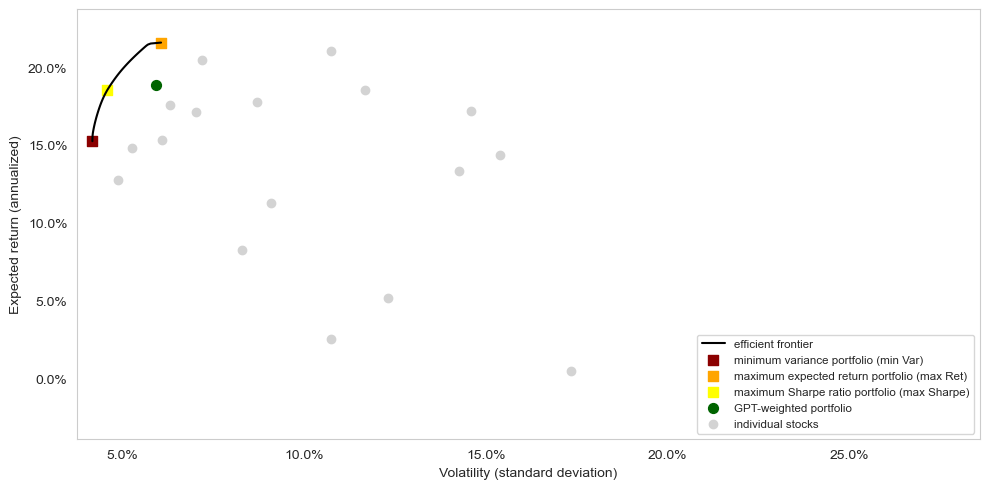

In [1009]:
# Compute expected returns, variances, and standard deviations for GPT weighted portfolio
gpt_weights = list(dfGPTweigts['GPTweights'].values.astype(float))
ret_gpt = np.dot(mu, gpt_weights)
var_gpt = np.dot(gpt_weights, np.dot(Q, gpt_weights))
std_gpt = np.sqrt(var_gpt)

fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]

# Plot efficient frontier for bounded case
ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')

# Plot volatility versus expected return for minimum variance portfolio
ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='s', s=50, color='darkred',
           label='minimum variance portfolio (min Var)')

# Plot volatility versus expected return for maximum return portfolio
ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='orange',
           label='maximum expected return portfolio (max Ret)')

# Plot maximum Sharpe portfolio
ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='s', s=50, color='yellow',
           label='maximum Sharpe ratio portfolio (max Sharpe)')

# Plot GPT weighted portfolio
ax.scatter(x=std_gpt, y=ret_gpt, marker='o', s=50, color='darkgreen', label='GPT-weighted portfolio')

# Plot volatility versus expected return for individual stocks
ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='lightgray', label='individual stocks')

# Format and display the final plot
ax.axis([0.9 * np.sqrt(var_front[0]), 1.2 * np.max(np.sqrt(np.diag(Q))), np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)),
         1.1 * ret_front[-1]])
ax.set_xlabel('Volatility (standard deviation)')  # Display percentage on x-axis
ax.set_ylabel('Expected return (annualized)')  # Display percentage on y-axis
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format x axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format y axis as percentage
ax.legend(loc="lower right", fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()

### Add asset weights for three portfolios (strategies (ii), (iii), (vi)) to Pandas DataFrame

In [1010]:
# sharpe_ratio = w_front[index].toList()
dfGPTweigts['maxRet'] = w_front[-1]
# dfGPTweigts['maxRet'] = w_maxRet
dfGPTweigts['minVar'] = w_front[0]
# dfGPTweigts['minVar'] = w_minVar
dfGPTweigts['maxSharpe'] = w_front[max_sharpe_ratio_index]

In [1011]:
dfGPTweigts

,GPTweights,maxRet,minVar,maxSharpe
ticker,,,,
AAPL,0.153061,0.100016,0.025000,0.100010
MSFT,0.122449,0.100011,0.025000,0.025003
AMZN,0.102041,0.024995,0.025000,0.024991
GOOGL,0.081633,0.100001,0.025000,0.024996
META,0.071429,0.024997,0.025000,0.024990
JNJ,0.061224,0.024990,0.100000,0.024995
V,0.051020,0.024999,0.072696,0.024997
JPM,0.051020,0.024993,0.056852,0.024991
PG,0.040816,0.049382,0.087741,0.100001


### Out-of-sample plots of cumulative returns

In [1012]:
## Calculate cumulative returns (out-of-sample) for plots

stocks_returns = df_returns_out

# Weights of all portfolios
weights = {
    "GPT": dfGPTweigts['GPTweights'],
    "Min Var": dfGPTweigts['minVar'],
    "Max Ret": dfGPTweigts['maxRet'],
    "Max Sharpe": dfGPTweigts['maxSharpe']
}

# Calculate cumulative returns for each portfolio
cumulative_returns = pd.DataFrame(index=stocks_returns.index)

for name, weight in weights.items():
    portfolio_return = (stocks_returns * weight).sum(axis=1)
    cumulative_returns[name] = (1 + portfolio_return).cumprod()

# Map ticker symbols to index names
index_names = {
    "^GSPC": "S&P 500"
}

# Calculate cumulative returns for each index
cumulative_returns[index_names['^GSPC']] = (1 + sp500index_outs['SP_Return']).cumprod()

# Convert index to datetime
cumulative_returns.index = pd.to_datetime(cumulative_returns.index)

# Filter the data for the specified period
outsample_data = cumulative_returns.loc[outsample_startdate:outsample_enddate]


Plot static figure

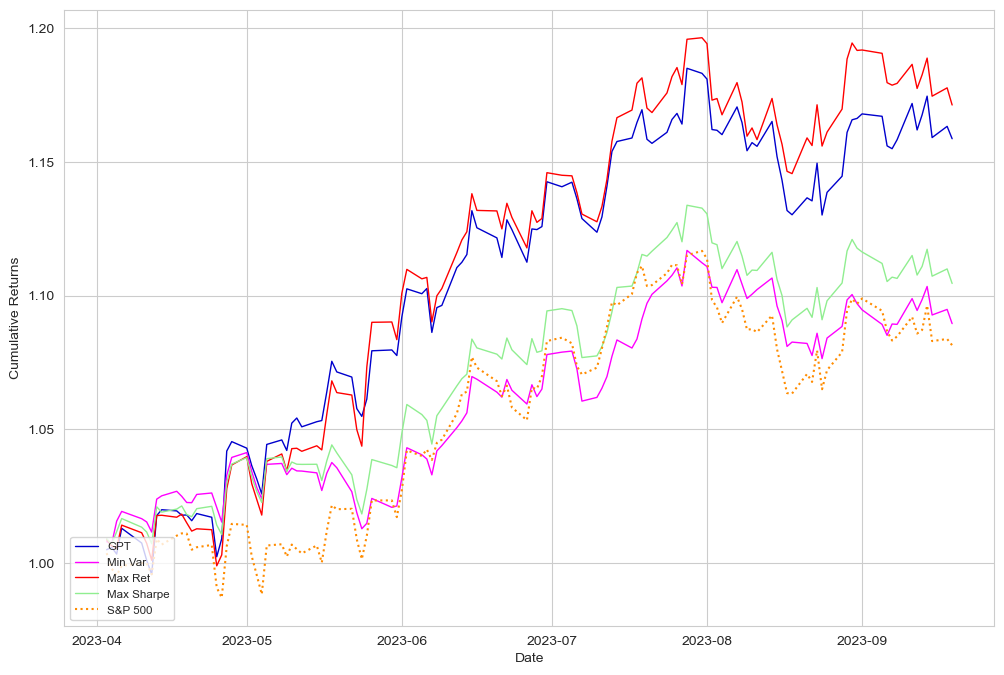

In [1013]:
# Define styles for different categories
styles = {
    "GPT": {'color': 'mediumblue', 'linestyle': '-', 'linewidth': 1},
    "Min Var": {'color': 'magenta', 'linestyle': '-', 'linewidth': 1},
    "Max Ret": {'color': 'red', 'linestyle': '-', 'linewidth': 1},
    "Max Sharpe": {'color': 'lightgreen', 'linestyle': '-', 'linewidth': 1},
    "S&P 500": {'color': 'darkorange', 'linestyle': ':', 'linewidth': 1.5}
    
}

fig, ax = plt.subplots(figsize=(12, 8))

# Plot each portfolio/index with its corresponding style
for column in outsample_data.columns:
    ax.plot(outsample_data.index, outsample_data[column], label=column, **styles[column])

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.grid(True)
ax.legend(loc='lower left', fontsize='small')

# Show the plot
plt.show()


Plot dynamic figure

In [1014]:
# Create a new figure
fig = go.Figure()

# Add the data for each portfolio and index to the figure
for column in outsample_data.columns:
    fig.add_trace(go.Scatter(x=outsample_data.index,
                             y=outsample_data[column],
                             mode='lines',
                             name=column))

# Customize the layout of the figure
fig.update_layout(
    title='Cumulative Returns of ' + str(
        len(gpt_weights)) + ' Asset Portfolios and SP&500 Index from April 2023 to Sept 2023',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"  # This will show the labels when you hover over the lines
)

# Show the figure
fig.show()

In [1015]:
## Add your own plots here

### Out-of-sample comparison of risk and reward measures (add your code here)

In [1016]:
# Annotate each point with strategy names
outsample_data


,GPT,Min Var,Max Ret,Max Sharpe,S&P 500
Date,,,,,
2023-04-03,1.004971,1.007977,1.008730,1.009118,1.003699
2023-04-04,1.005834,1.007161,1.006416,1.007069,0.997880
2023-04-05,1.003359,1.015668,1.005614,1.011753,0.995393
2023-04-06,1.012974,1.019302,1.014166,1.016632,0.998956
2023-04-10,1.007468,1.016575,1.011317,1.013395,0.999951
...,...,...,...,...,...
2023-09-13,1.167579,1.098511,1.182541,1.110902,1.087151
2023-09-14,1.174568,1.103409,1.188798,1.117313,1.096315
2023-09-15,1.159084,1.092748,1.174559,1.107254,1.082985


In [1017]:
Q_out = df_returns_out[tickers_final].cov() * scalef
Q_out

,AAPL,MSFT,AMZN,GOOGL,META,JNJ,V,JPM,PG,WMT,UNH,MA,DIS,HD,INTC,VZ,KO,PEP,ADBE,NVDA
AAPL,0.008357,0.004789,0.003363,0.004301,0.006640,-0.000148,0.002386,0.002090,0.001307,0.000911,0.001019,0.002728,0.002661,0.001989,0.004017,0.002023,0.001114,0.000989,0.006370,0.007394
MSFT,0.004789,0.012560,0.008161,0.005417,0.008918,-0.001031,0.001813,0.000394,0.001015,0.000453,0.000712,0.002499,0.002555,-0.000065,0.004995,0.000954,0.000250,0.000973,0.008519,0.013658
AMZN,0.003363,0.008161,0.020314,0.007977,0.011071,-0.001225,0.001852,0.000519,0.001392,0.000631,-0.000631,0.002638,0.004172,0.001818,0.007406,0.001832,-0.000118,0.000688,0.008582,0.007654
GOOGL,0.004301,0.005417,0.007977,0.013617,0.009251,0.000175,0.001948,0.001260,0.001163,0.000575,0.000041,0.003015,0.001760,0.000591,0.002530,0.001072,0.000894,0.001108,0.005437,0.009057
META,0.006640,0.008918,0.011071,0.009251,0.023693,-0.000909,0.002733,0.002643,0.001722,0.000649,0.001028,0.003612,0.004595,0.003598,0.010229,0.004050,0.000669,0.001340,0.010837,0.013683
JNJ,-0.000148,-0.001031,-0.001225,0.000175,-0.000909,0.006865,0.000007,0.000263,0.001621,0.001465,0.002090,0.000191,-0.000576,-0.000091,-0.000285,0.000516,0.001718,0.002339,-0.000892,-0.004849
V,0.002386,0.001813,0.001852,0.001948,0.002733,0.000007,0.004948,0.002464,0.001007,0.000716,0.000966,0.004155,0.002664,0.001770,0.002816,0.000442,0.000783,0.000877,0.004120,0.003295
JPM,0.002090,0.000394,0.000519,0.001260,0.002643,0.000263,0.002464,0.008244,0.000623,0.000635,0.000853,0.002700,0.002722,0.003169,0.001642,0.000147,0.001035,0.000377,0.003731,0.005224
PG,0.001307,0.001015,0.001392,0.001163,0.001722,0.001621,0.001007,0.000623,0.003995,0.001505,0.001274,0.000904,0.000883,0.001310,0.001276,0.001840,0.001932,0.002351,0.001349,-0.001099
WMT,0.000911,0.000453,0.000631,0.000575,0.000649,0.001465,0.000716,0.000635,0.001505,0.002785,0.001244,0.001080,0.001227,0.001332,0.001767,0.001050,0.001087,0.001558,0.000404,-0.000916


#### Plot Out-of-sample comparison of risk and reward measures


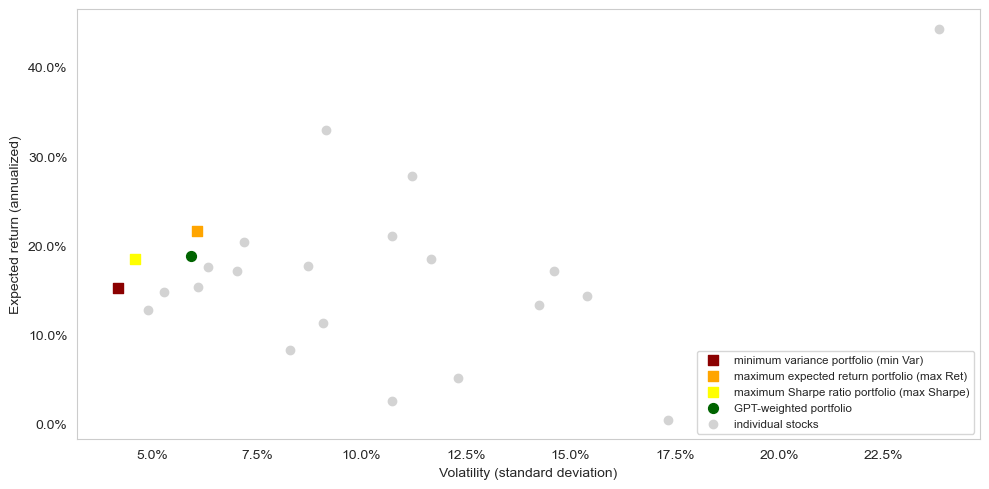

In [1018]:
gpt_weights = list(dfGPTweigts['GPTweights'].values.astype(float))
ret_gpt = np.dot(mu, gpt_weights)
var_gpt = np.dot(gpt_weights, np.dot(Q_out, gpt_weights))
std_gpt = np.sqrt(var_gpt)

fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]


# Plot volatility versus expected return for minimum variance portfolio
ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='s', s=50, color='darkred',
           label='minimum variance portfolio (min Var)')

# Plot volatility versus expected return for maximum return portfolio
ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='orange',
           label='maximum expected return portfolio (max Ret)')

# Plot maximum Sharpe portfolio
ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='s', s=50, color='yellow',
           label='maximum Sharpe ratio portfolio (max Sharpe)')

# Plot GPT weighted portfolio
ax.scatter(x=std_gpt, y=ret_gpt, marker='o', s=50, color='darkgreen', label='GPT-weighted portfolio')

# Plot volatility versus expected return for out-of-sample individual stocks
ax.scatter(x=np.sqrt(np.diag(Q_out)), y=mu, color='lightgray', label='individual stocks')
ax.set_xlabel('Volatility (standard deviation)')  # Display percentage on x-axis
ax.set_ylabel('Expected return (annualized)')  # Display percentage on y-axis
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format x axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format y axis as percentage
ax.legend(loc="lower right", fontsize='small')
ax.grid()
plt.tight_layout()
plt.show()

### Compute the maximum drawdown

In [1019]:
max_drawdowns = {}

for column in cumulative_returns.columns:
    cum_returns = cumulative_returns[column]
    # Calculate the cumulative maximum value up to each point
    cumulative_max = cum_returns.cummax()

    # Calculate the drawdown by subtracting cumulative_max from cumulative_returns
    drawdown = (cum_returns - cumulative_max) / cumulative_max

    # Maximum drawdown is the maximum value in the drawdown series
    max_drawdown = drawdown.min()
    max_drawdowns[column] = max_drawdown

max_drawdowns

{'GPT': -0.04629567714379598,
 'Min Var': -0.036225647461738744,
 'Max Ret': -0.042472842223741536,
 'Max Sharpe': -0.040124255140709414,
 'S&P 500': -0.047777710388915214}

#### Compute Value-at-Risk

In [1063]:
stocks_returns = df_returns_out

# Weights of all portfolios
weights = {
    "GPT": dfGPTweigts['GPTweights'],
    "Min Var": dfGPTweigts['minVar'],
    "Max Ret": dfGPTweigts['maxRet'],
    "Max Sharpe": dfGPTweigts['maxSharpe']
}
     
portfolio_vars = {}
portfolio_returns = {}
for name, weight in weights.items():
    portfolio_returns[name] = (stocks_returns * weight).sum(axis=1)
    portfolio_vars[name] = portfolio_returns[name].quantile(0.01)

print(portfolio_vars)

{'GPT': -0.015795376931487543, 'Min Var': -0.0096283271692865, 'Max Ret': -0.014764868049207465, 'Max Sharpe': -0.010832373337824731}


In [1075]:
stocks_returns = mu

df_returns

# Weights of all portfolios
weights = {
    "GPT": dfGPTweigts['GPTweights'],
    "Min Var": dfGPTweigts['minVar'],
    "Max Ret": dfGPTweigts['maxRet'],
    "Max Sharpe": dfGPTweigts['maxSharpe']
}

portfolio_vars = {}
portfolio_returns = {}
for name, weight in weights.items():
    portfolio_returns[name] = (stocks_returns * weight).sum(axis=0)
    portfolio_vars[name] = np.quantile(portfolio_returns[name], 0.01)

print(portfolio_vars)

{'GPT': 0.18834821861800305, 'Min Var': 0.15236647253709168, 'Max Ret': 0.21570941188454404, 'Max Sharpe': 0.18499133195507786}


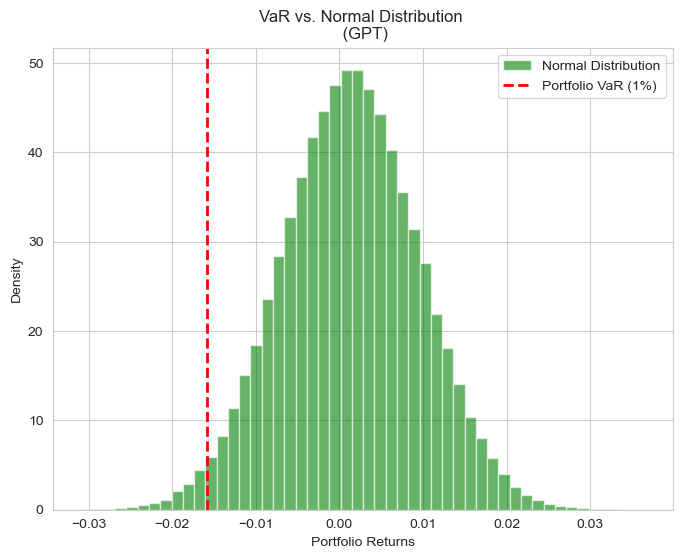

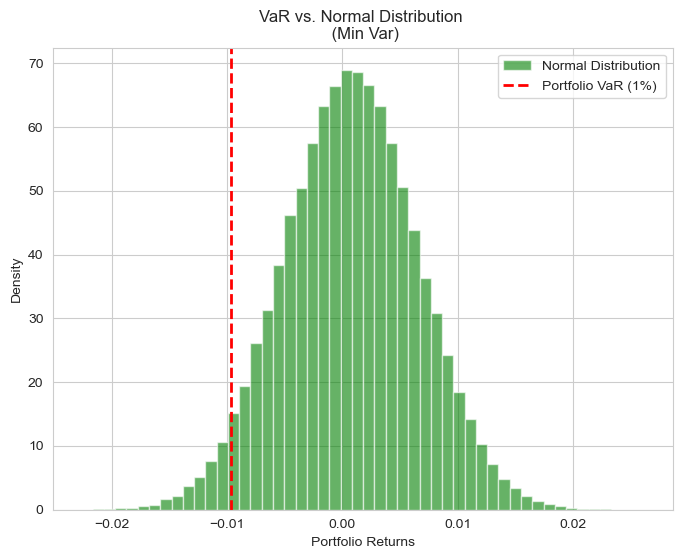

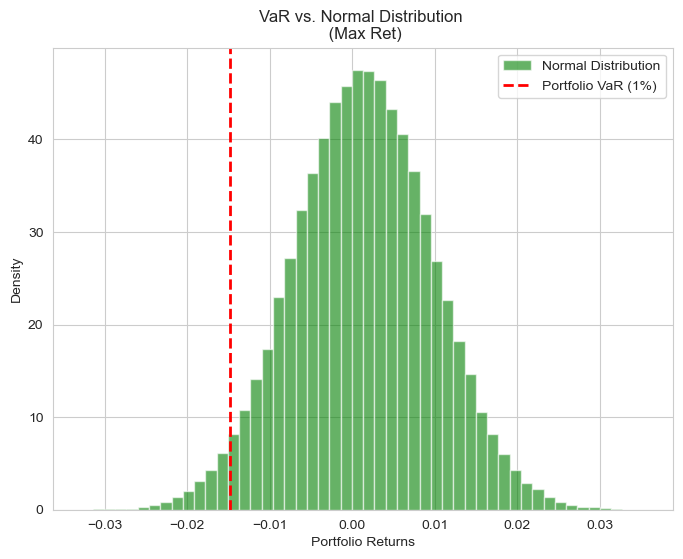

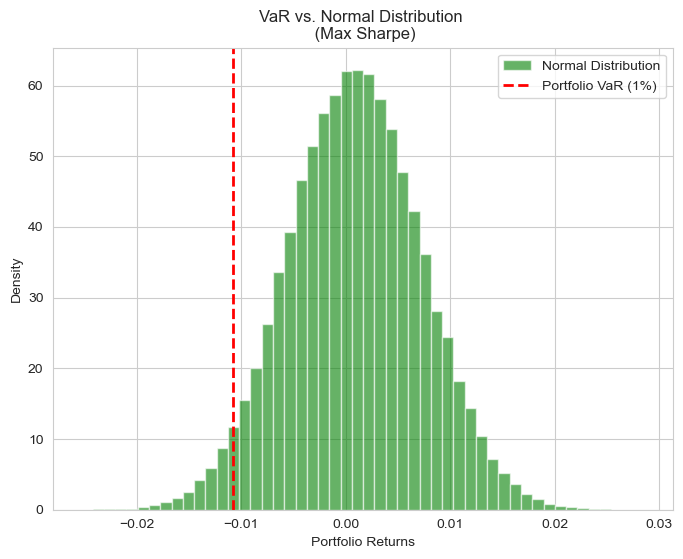

In [1021]:
for name, _ in weights.items():
    portfolio_mean = portfolio_returns[name].mean()
    portfolio_std = portfolio_returns[name].std()
    num_samples = 100000  # You can adjust the number of samples as needed
    normal_samples = np.random.normal(portfolio_mean, portfolio_std, num_samples)
    portfolio_var_1_percent = portfolio_vars[name]
    normal_var_1_percent = np.percentile(normal_samples, 1)
    
    plt.figure(figsize=(8, 6))
    
    # Plot histogram of normal samples
    plt.hist(normal_samples, bins=50, density=True, alpha=0.6, color='g', label='Normal Distribution')
    
    # Mark 1% quantiles
    plt.axvline(x=portfolio_var_1_percent, color='r', linestyle='--', linewidth=2, label='Portfolio VaR (1%)')
    
    plt.xlabel('Portfolio Returns')
    plt.ylabel('Density')
    plt.title(f'VaR vs. Normal Distribution \n ({name})')
    plt.legend()
    plt.show()



In [1021]:
# Minimum Variance Portfolio:
#     Variance: 0.0017481417709178965
#     Return: 0.15236647253709168
#     Sharpe Ratio: 2.9266724252142455
# 
# 
# Maximum Return Portfolio:
#     Variance: 0.0036831709796958114
#     Return: 0.215709411884544
#     Sharpe Ratio: 3.0600109079683917
# 
# Maximum Sharpe Ratio Portfolio:
#     Variance: 0.0021025770626225547
#     Return: 0.1849913319550779
#     Sharpe Ratio: 4.004367143533908
# 
# GPT weighted portfolio:
#     Variance: 0.0035037216317852374
#     Return: 0.18834821861800308
#     Sharpe Ratio: 2.67515151619856
# 
# {'GPT': -0.015795376931487543, 'Min Var': -0.0096283271692865, 'Max Ret': -0.014764868049207465, 'Max Sharpe': -0.010832373337824731}
# {'GPT': -0.04629567714379598,
#  'Min Var': -0.036225647461738744,
#  'Max Ret': -0.042472842223741536,
#  'Max Sharpe': -0.040124255140709414,
#  'S&P 500': -0.047777710388915214}

In [1055]:

# Given dictionary
portfolio_results = {
    'Minimum Variance Portfolio' : [1.09, 0.0017481417709178965, 0.15236647253709168, 2.9266724252142455, -0.0096283271692865, -0.036225647461738744],
    'Maximum Return Portfolio' : [1.17, 0.0036831709796958114, 0.215709411884544, 3.0600109079683917, -0.014764868049207465, -0.042472842223741536],
    'Maximum Sharpe Ratio Portfolio' : [1.10, 0.0021025770626225547, 0.1849913319550779, 4.004367143533908, -0.010832373337824731, -0.040124255140709414],
    'GPT weighted portfolio' : [1.15, 0.0035037216317852374, 0.18834821861800308, 2.67515151619856, -0.015795376931487543, -0.04629567714379598],
}

# Creating a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results, index=['Cumulative return','Variance', 'Return', 'Sharpe Ratio', 'Max Drawdown', 'Value-at-Risk'])
# portfolio_results_df = portfolio_results_df * 100

portfolio_results_df = portfolio_results_df.T
portfolio_results_df['Volatility'] = np.sqrt(portfolio_results_df['Variance'])
portfolio_results_df = portfolio_results_df.drop(columns=['Variance'])

portfolio_results_df = portfolio_results_df * 100
portfolio_results_df['Sharpe Ratio'] = portfolio_results_df['Sharpe Ratio']/100

portfolio_results_df.round(2)

,Cumulative return,Return,Sharpe Ratio,Max Drawdown,Value-at-Risk,Volatility
Minimum Variance Portfolio,109.0,15.24,2.93,-0.96,-3.62,4.18
Maximum Return Portfolio,117.0,21.57,3.06,-1.48,-4.25,6.07
Maximum Sharpe Ratio Portfolio,110.0,18.50,4.00,-1.08,-4.01,4.59
GPT weighted portfolio,115.0,18.83,2.68,-1.58,-4.63,5.92
